# Taxonomic analysis

In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

In this notebook we'll describe the seasonal turnover in taxonomy. To be able to draw meaningful conclusions from our metatranscriptomic data, we need to:
1. Annotate the assembled transcripts with relevant taxonomic information and assess the completeness of that information
2. Combine taxonomically annotated transcripts with (normalized) read counts
3. Visualize Relative expression of groups of a given taxonomic level per month

## Annotation
First, quality controlled reads were aligned to the [Tara oceans' collection of SMAGs](../scripts/Tara_MAG_mapping.pbs) using minimap2 to check their representation in the genome collection. 

Second, assembled transcripts were aligned to some standard reference databases ([MMETSP](../scripts/MMETSP_taxonomic_annotation.pbs), [PhyloDB](../scripts/phyloDB_taxonomic_annotation.pbs), and [MATOU](../scripts/Tara_MATOU_mapping.pbs)) using mmseqs2. Let's start by verifying the completeness of these annotations.

### SMAGs alignment
First, low complexity alignments were removed from the resulting BAM files using the program [bamFilters](https://github.com/institut-de-genomique/bamFilters). Only alignments covering at least 80% of a given metatranscriptomic contig with at least 95% of identity were retained. The above is the same parameter setting in Delmont et al. 2022 "Functional repertoire convergence of distantly related eukaryotic plankton lineages abundant in the sunlit ocean". The resulting BAM files were used to calculate the number of well-mapped reads per sample, as follows:

```bash
# Get relevant folders
bamfilters_dir=${working_dir}'data/SMAG_alignment/bamfilters/'

# Load modules
module load SAMtools

# Calculate number of mapped reads per sample
for sample in $(awk -F";" '{if (NR!=1) print $1}' samples.csv); do
    echo ${sample};
    samtools flagstat ${bamfilters_dir}${sample}.bam;
done
```

The results are stored in [a mapping rates excel file](data/annotation/mapping_rates_SMAG.xlsx). We can see that mapping rates are low (2.59% on average). Except for April, where the average mapping rate increases to 14%. I've checked to which SMAG this can be attributed, and in the 3 samples with high mapping rates we find that for April, a lot of months indeed map to *Phaeocystis* MAGs or isolates! The identity of reference MAGs that have reads aligned to them can be checked automatically using: 

```bash
for sample in $(awk -F";" '{if (NR!=1) print $1}' samples.csv); do
    echo $sample;
    samtools view  ${bamfilters_dir}${sample}.bam | awk -F '\t' '{print $3}' | awk -F "_" 'BEGIN {OFS = "_"} {print $1, $2, $3, $4, $5}' | sort | uniq -c | sort -nr;
done > data/SMAG_alignment/SMAGs_per_sample.txt
```

When this is run, the results in the .txt file can be cross-referenced to the annotations from [this table](https://ars.els-cdn.com/content/image/1-s2.0-S2666979X22000477-mmc5.xlsx) (beware; will start downloading!) to check taxonomical identity.

### PhyloDB

From the clustered assembly, 3,705,883 peptides were predicted. Let's check how many of them have a taxonomic annotation by aligning against PhyloDB. We only take into account annotations with % sequence identity above 90. 

```bash
cat data/annotation/taxonomy_phyloDB/phylodb_nobacktrace.firsthit.90plus_alnscore.m8 | wc -l
```

This returns 867,645. This is 23.41% of all predicted peptides. Using information from the flowcam experts, and searching for additional transcriptome sets, we could extend the PhyloDB with 4 species. For more info see [this notebook](../phyloDB_expansion.ipynb). Let's verify how many peptides have a taxonomic annotation now:

```bash
cat data/annotation/taxonomy_phyloDB_extended/phylodb_extended.firsthit.90plus_alnscore.m8 | wc -l
```

This returns 954,136. That means we increased our annotation to 25.75%, an increase of 2.34%! Still, with 75% of the peptides not having a taxonomic annotation, we have to be very careful with interpretations.

In [ ]:
## Load PhyloDB alignments
data = pd.read_table('../../data/annotation/taxonomy_phyloDB_extended/phylodb_extended.firsthit.90plus_alnscore.m8',  engine='pyarrow', header=None)
print(f'The mmseqs alignment has {len(data)} hits with a >90 % identity')
data.columns = ['query_id', 'target_id', 'p_ident', 'alnlen', 'mismatch', 'gapopen', 'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bits']
print(f'The mmseqs alignment contains {len(data["query_id"].unique())} unique query sequences')
# Fix transcript names in the first column so that they equal the transcript identifiers in the count files
data.iloc[:, 0] = data.iloc[:, 0].str.split(".", expand=True).drop(columns=1)
print(f'The mmseqs alignment contains {len(data["query_id"].unique())} unique query sequences')

# Add taxonomic information
taxonomy = pd.read_table('../../data/annotation/taxonomy_phyloDB_extended/phylodb_1.076.taxonomy_extended.txt')
print(f'The taxonomy file contains {len(taxonomy)} rows')
annotation = pd.read_table('../../data/annotation/taxonomy_phyloDB_extended/phylodb_1.076.annotations_extended.txt', engine='pyarrow', header=None)
print(f'The annotation file contains {len(annotation)} rows, linking transcript IDs to their taxonomy and function')
annotation.columns = ['target_id', 'code', 'strain_name', 'function']

# Add the taxonomy information to the data
# data = data.merge(annotation, left_on='target_id', right_on='target_id', how='left')
data = data.merge(annotation, left_on='target_id', right_on='target_id')
print(f'The alignment merged with annotation file contains {len(data)} rows')

data = data.merge(taxonomy, left_on='strain_name', right_on = 'strain_name')
print(f'The data merged with the taxonomy  file contains {len(data)} rows')

data = data.drop(columns=['code', 'peptide_count'])
# Expand taxonomy path in relevant columns
data[['kingdom', 'superphylum', 'phylum', 'class', 'order', 'family', 'genus', 'species']] = data['taxonomy'].str.split(';', expand = True)

# View data
data.head()

### EukProt

In [2]:
## Load eukprot annotations
#p_id='90'
p_id='60'

eukprot_annotation = pd.read_table(f'../../data/annotation/taxonomy_eukprot/eukprot_DB.firsthit.{p_id}plus_alnscore.m8', header=None)
print(f'The eukprot annotation file contains {len(eukprot_annotation)} rows')
# Fix transcript names in the first column so that they equal the transcript identifiers in the count files
eukprot_annotation.iloc[:, 0] = eukprot_annotation.iloc[:, 0].str.split(".", expand=True).drop(columns=1)

## In the second column, split of the EukProt ID off
eukprot_ID = eukprot_annotation.iloc[:, 1].str.split("_", expand=True)[0]
eukprot_annotation.iloc[:, 1] = eukprot_ID
eukprot_annotation.columns = ['query_id', 'target_id', 'p_ident', 'alnlen', 'mismatch', 'gapopen', 'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bits']

## Add taxonomic information
eukprot_taxonomy = pd.read_table('../../data/annotation/taxonomy_eukprot/EukProt_included_data_sets.v03.2021_11_22.txt')
print(f'The eukprot taxonomy file contains {len(eukprot_taxonomy)} rows')

# Drop the columns that are not needed
eukprot_taxonomy.drop(columns=['Previous_Names', 'Replaces_EukProt_ID', 'Data_Source_URL', 'Data_Source_Name', 'Paper_DOI', 'Actions_Prior_to_Use',
       'Data_Source_Type', 'Notes', 'Columns_Modified_Since_Previous_Version', 'Merged_Strains',
       'Alternative_Strain_Names', '18S_Sequence_GenBank_ID', '18S_Sequence',
       '18S_Sequence_Source', '18S_Sequence_Other_Strain_GenBank_ID',
       '18S_Sequence_Other_Strain_Name', '18S_and_Taxonomy_Notes'], inplace=True)

# Swap the _ to a space in the Name_to_Use column
eukprot_taxonomy['Name_to_Use'] = eukprot_taxonomy['Name_to_Use'].str.replace('_', ' ')

# Merge the annotation and taxonomy files
eukprot_annotation = eukprot_annotation.merge(eukprot_taxonomy, left_on='target_id', right_on='EukProt_ID', how='left')
print(f'The eukprot annotation merged with taxonomy file contains {len(eukprot_annotation)} rows')

# Drop the columns that are not needed
eukprot_annotation.drop(columns=['target_id', 'gapopen', 'qstart', 'qend', 'tstart', 'tend', 'evalue', 'bits'], inplace=True)

The eukprot annotation file contains 2351886 rows
The eukprot taxonomy file contains 993 rows
The eukprot annotation merged with taxonomy file contains 2351886 rows


In [3]:
eukprot_annotation.head()

,query_id,p_ident,alnlen,mismatch,EukProt_ID,Name_to_Use,Strain,Genus_UniEuk,Epithet_UniEuk,Supergroup_UniEuk,Taxogroup1_UniEuk,Taxogroup2_UniEuk,Taxonomy_UniEuk
0,c_000004644880,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans
1,c_000001576219,0.859,178,25,EP00113,Trichoplax adhaerens,NaN,Trichoplax,adhaerens,Opisthokonta,Metazoa,Placozoa,Eukaryota;Amorphea;Obazoa;Opisthokonta;Holozoa;Choanozoa;Metazoa;Animalia;'parahoxozoa';Placozoa;Trichoplax;Trichoplax adhaerens
2,c_000001590569,0.717,144,40,EP00090,Calanus glacialis,NaN,Calanus,glacialis,Opisthokonta,Metazoa,Arthropoda,Eukaryota;Amorphea;Obazoa;Opisthokonta;Holozoa;Choanozoa;Metazoa;Animalia;'parahoxozoa';Bilateria;Protostomia;Ecdysozoa;Panarthropoda;Arthropoda;Mandibulata;Pancrustacea;Copepoda;Calanoida;'megacalanoids';Calanidae;Calanus;Calanus glacialis
3,c_000001590608,0.881,270,28,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans
4,c_000001612250,0.862,872,120,EP00521,Asterionellopsis glacialis,CCMP134,Asterionellopsis,glacialis,Stramenopiles,Ochrophyta,Diatomeae,Eukaryota;Diaphoretickes;Sar;Stramenopiles;'GOS clade';Gyrista;Ochrophyta;'BD clade';Diatomeae;Bacillariophytina;Bacillariophyceae;Asterionellopsis;Asterionellopsis glacialis;strain CCMP-134


### Consensus
Now, let's combine the PhyloDB and Eukprot annotations. When do they find the same and when do they find non-matching annotations?

In [ ]:
eukprot_annotation['query_id'].isin(data['query_id']).value_counts()

In [ ]:
# Merge the eukprot annotation with the data
data_consensus = data.merge(eukprot_annotation, left_on='query_id', right_on='query_id', how='outer')
data_consensus = data_consensus[['query_id', 'kingdom', 'superphylum',
       'phylum', 'class', 'order', 'family', 'genus', 'species',
       'Name_to_Use', 'Strain', 'Genus_UniEuk', 'Epithet_UniEuk', 'Supergroup_UniEuk',
       'Taxogroup1_UniEuk', 'Taxogroup2_UniEuk']]

In [ ]:
# Print how many times an annotation was found with PhyloDB
print(f'The number of species annotations found with PhyloDB is {len(data["query_id"].unique())}')

# Print how many times an annotation was found with Eukprot
print(f'The number of species annotations found with Eukprot is {len(eukprot_annotation["query_id"])}')

data_consensus2 = data_consensus.dropna()
# Print how many times the annotation was the same
confirmed_annotations_count = (data_consensus2['species'] == data_consensus2['Name_to_Use']).sum()
print(f'The number of confirmed annotations from both reference databases at the species level is {confirmed_annotations_count}')

# Print how many times the annotation was different
unconfirmed_annotations_count = (data_consensus2['species'] != data_consensus2['Name_to_Use']).sum()
print(f'The number of different annotations from both reference databases at the species level is {unconfirmed_annotations_count}')

# Print how many times the annotation was the same
confirmed_annotations_count = (data_consensus2['genus'] == data_consensus2['Genus_UniEuk']).sum()
print(f'The number of confirmed annotations from both reference databases at the genus level is {confirmed_annotations_count}')

# Print how many times the annotation was different
unconfirmed_annotations_count = (data_consensus2['genus'] != data_consensus2['Genus_UniEuk']).sum()
print(f'The number of different annotations from both reference databases at the genus level is {unconfirmed_annotations_count}')

# Print how many times the annotation was the same
confirmed_annotations_count = (data_consensus2['superphylum'] == data_consensus2['Supergroup_UniEuk']).sum()
print(f'The number of confirmed annotations from both reference databases at the superphylum level is {confirmed_annotations_count}')

# Print how many times the annotation was different
unconfirmed_annotations_count = (data_consensus2['superphylum'] != data_consensus2['Supergroup_UniEuk']).sum()
print(f'The number of different annotations from both reference databases at the superphylum level is {unconfirmed_annotations_count}')

In [ ]:
mismatches = data_consensus2[data_consensus2['superphylum'] != data_consensus2['Supergroup_UniEuk']]
mismatches = mismatches[['species', 'Name_to_Use']]
mismatches = mismatches.drop_duplicates()
print(f'The number of different annotations from both reference databases at the superphylum level is {len(mismatches)}')

In [ ]:
len(mismatches['species'].unique())

In [ ]:
len(mismatches['Name_to_Use'].unique())

In [ ]:
mismatches['species'].value_counts()

In [ ]:
mismatches['Name_to_Use'].value_counts()

The PhyloDB and EukProt do show some differences. Let's run below taxonomic annotation with both datasets.

#### Remarks

In [ ]:
# 1. Some of the annotation file target IDs are not unique (0.5% of the data, see below)
print((len(annotation['target_id'].unique()) / len(annotation['target_id'])) * 100)

In [ ]:
# 2. Using a cut off of 90% identity, some assembled contigs are annotated either to the same or to multiple species, these were lost in the merge step
# Group data by 'query_id' and count the number of occurrences of each 'target_id'
grouped_data = data.groupby(['query_id', 'target_id']).size().reset_index(name='counts')

# filter the groupby dataframe for count greater than 1
multiple_target_id = grouped_data[grouped_data['counts'] > 1]

print(len(multiple_target_id) / len(data) * 100)

multiple_target_id.sort_values(by='counts', ascending=False).head()

In [ ]:
# 3. Are all target IDs in the data in the annotation file?
data[~data['target_id'].isin(annotation['target_id'])]['target_id']

### MMETSP

MMETSP is a subset of PhyloDB. If we assess percent of the peptides assembled we should get a lower number than for the PhyloDB:

```bash
cat data/annotation/taxonomy_MMETSP/marmmetsp.firsthit.90plus_alnscore.m8 | wc -l
```

Indeed returns 851,563. This is a 98% of the PhyloDB annotation. 

## Add TPM read counts

In order to have an understanding of the taxonomic composition of a sample, we need to combine the taxonomically annotated transcripts with their read counts. Read counts were generated using [kallisto](https://pachterlab.github.io/kallisto/about) in the [snakemake workflow](../../snakefile). 

In [3]:
# Load the necessary count data
counts = pd.read_csv('../../data/kallisto/tpm.csv', engine='pyarrow')
## This is the transcript read mapping, prior to protein prediction!
# Rename the first column to transcript_id
counts = counts.rename(columns={'target_id': 'transcript_id'})
print(f'{len(counts)} transcripts were quantified (on the nucleotide level) in the kallisto run')
# Transform the data to the long format
counts = counts.melt(id_vars=['transcript_id'],var_name='sample', value_name='TPM')
counts.head()

7113509 transcripts were quantified (on the nucleotide level) in the kallisto run


,transcript_id,sample,TPM
0,c_000000000001,B_120_S11,0.233985
1,c_000000000002,B_120_S11,0.000000
2,c_000000000003,B_120_S11,0.000000
3,c_000000000004,B_120_S11,0.000000
4,c_000000000005,B_120_S11,0.000000


In [5]:
# Combine count and annotation data together
data_expr = data.merge(counts, left_on='query_id', right_on='transcript_id', how='left')
data_expr = data_expr.drop(columns='query_id')

# Add sample metadata
meta = pd.read_csv('../../samples.csv', sep=';', index_col=0)
data_expr = data_expr.merge(meta, left_on= 'sample', right_on= 'sample', how = 'left')

# View data
print(f'{len(data_expr)} rows are in the data, which should be the amount of predicted proteins times the number of samples')
data_expr.head()

NameError: name 'data' is not defined

In [4]:
# Combine count and Eukprot annotation data together
data_expr2 = eukprot_annotation.merge(counts, left_on='query_id', right_on='transcript_id', how='left')
data_expr2 = data_expr2.drop(columns='query_id')

# Add sample metadata
meta = pd.read_csv('../../samples.csv', sep=';', index_col=0)
data_expr2 = data_expr2.merge(meta, left_on= 'sample', right_on= 'sample', how = 'left')

# View data
print(f'{len(data_expr2)} rows are in the data, which should be the amount of predicted proteins times the number of samples')
data_expr2.head()

145816932 rows are in the data, which should be the amount of predicted proteins times the number of samples


,p_ident,alnlen,mismatch,EukProt_ID,Name_to_Use,Strain,Genus_UniEuk,Epithet_UniEuk,Supergroup_UniEuk,Taxogroup1_UniEuk,Taxogroup2_UniEuk,Taxonomy_UniEuk,transcript_id,sample,TPM,date,time,month,station
0,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans,c_000004644880,B_120_S11,0.0,18/08/2020,9:40,August_2020,120
1,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans,c_000004644880,5_120_S50,0.0,18/05/2021,20:25,May_2021,120
2,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans,c_000004644880,A_780_S3,0.0,22/07/2020,12:30,July_2020,780
3,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans,c_000004644880,5_130_S45,0.0,18/05/2021,9:45,May_2021,130
4,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans,c_000004644880,C_ZG02_S17,0.0,30/09/2020,16:20,September_2020,ZG02


In [ ]:
data_expr.columns

So we now have 59,238,830 rows (62 samples *  955,465 annotated peptides) for the PhyloDB annotation & 29,052,766 (62 samples * 468,593 annotated peptides).

In [5]:
# Create a species x sample TPM matrix and save it for later use
grouped_data = data_expr[['species', 'sample', 'TPM']].groupby(['species', 'sample']).agg({'TPM': 'sum'})
grouped_data = grouped_data.reset_index()
# pivot the data to wide format
grouped_data = grouped_data.pivot(index='species', columns='sample', values='TPM')
# save the data
grouped_data.to_csv('../../data/analysis/phylodb_species_sample_TPM_sum.csv')

# Same for the Eukprot data
grouped_data2 = data_expr2[['Name_to_Use', 'sample', 'TPM']].groupby(['Name_to_Use', 'sample']).agg({'TPM': 'sum'})
grouped_data2 = grouped_data2.reset_index()
# pivot the data to wide format
grouped_data2 = grouped_data2.pivot(index='Name_to_Use', columns='sample', values='TPM')
# save the data
grouped_data2.to_csv(f'../../data/analysis/eukprot_species_{p_id}_sample_TPM_sum.csv')

# Same for the Eukprot data
grouped_data2 = data_expr2[['Genus_UniEuk', 'sample', 'TPM']].groupby(['Genus_UniEuk', 'sample']).agg({'TPM': 'sum'})
grouped_data2 = grouped_data2.reset_index()
# pivot the data to wide format
grouped_data2 = grouped_data2.pivot(index='Genus_UniEuk', columns='sample', values='TPM')
# save the data
grouped_data2.to_csv(f'../../data/analysis/eukprot_genus_{p_id}_sample_TPM_sum.csv')

# Same for the Eukprot data
grouped_data2 = data_expr2[['Taxogroup2_UniEuk', 'sample', 'TPM']].groupby(['Taxogroup2_UniEuk', 'sample']).agg({'TPM': 'sum'})
grouped_data2 = grouped_data2.reset_index()
# pivot the data to wide format
grouped_data2 = grouped_data2.pivot(index='Taxogroup2_UniEuk', columns='sample', values='TPM')
# save the data
grouped_data2.to_csv(f'../../data/analysis/eukprot_order_{p_id}_sample_TPM_sum.csv')

NameError: name 'data_expr' is not defined

### Visualise
Now, recombine the count data with PhyloDB annotations.

In [ ]:
# Define a taxonomic level of interest
tax_level = 'species'

In [ ]:
# Now I want to obtain relative expression of taxonomic identifier per month
# Normalize so that the sum of all groups per month is 1, and then plot a general figure
# First, remove transcripts that fall below the detection limit of 1 TPM
grouped_df = data_expr[data_expr['TPM'] > 1][[tax_level, 'month', 'TPM']]
grouped_df = grouped_df.groupby([tax_level, 'month']).agg({'TPM':['sum', 'mean', 'min', 'max']})
grouped_df.columns = ['TPM_sum', 'TPM_mean', 'TPM_min', 'TPM_max']
grouped_df  = grouped_df.reset_index()
grouped_df['month'] = pd.Categorical(grouped_df['month'], ["July_2020", "August_2020", "September_2020", 
                                                        "November_2020", "December_2020", "January_2021", 
                                                        "February_2021", "April_2021", "May_2021", 
                                                        "June_2021", "July_2021"])

# Normalise mean of TPM values to the total TPM of that month
grouped_df["rel_expression_per_month"] = grouped_df.TPM_sum / grouped_df.groupby('month').TPM_sum.transform('sum')
# Round relative expression values, this however messes up the figure
# grouped_df['rel_expression_per_month'] = grouped_df['rel_expression_per_month'].round(2)
print(len(grouped_df))
grouped_df.head()

#### PCA

In [ ]:
# Prepare data for PCA
pca_data = data_expr[[tax_level, 'sample', 'TPM']].pivot_table(index=tax_level, columns='sample', values='TPM', aggfunc='sum')

# Add metadata to the PCA data
meta = pd.read_csv('../../samples.csv', sep=';', index_col=0)
month_order = ["July_2020", "August_2020", "September_2020", "November_2020", 
                "December_2020", "January_2021", "February_2021", "April_2021", 
                "May_2021", "June_2021", "July_2021"]

In [ ]:
# Check log row sums distribution
pca_data.apply(np.log1p).sum(axis=1).hist(bins=100)

In [ ]:
np.log10(30)

In [ ]:
pca_data[pca_data < 30] = 0
# Remove rows with only zeros
pca_data = pca_data[pca_data.sum(axis=1) != 0]

# log transform the transposed data
data_log = np.log(pca_data.transpose() +1)

# Check if the indices are the same
assert (data_log.index == meta.index).all()

In [ ]:
# Merge environmental variables with gene expression data
env_variables = pd.read_csv("../../data/environmental/samples_env.csv", sep=";")
env_variables = env_variables.set_index('sample')
pca_data = data_log.merge(env_variables, left_index=True, right_on='sample', how='left')

# Calculate euclidean distance between samples
dist = squareform(pdist(pca_data.drop(columns=env_variables.columns)))

# Perform PCA on gene expression data, ignore columns that are also in the environmental variables
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(dist)

# Add principal components to the data
pca_data['PC1'] = principalComponents[:, 0]
pca_data['PC2'] = principalComponents[:, 1]

# Create a color dictionary for the months
month_color_dict = dict(zip(meta['month'].unique(), sns.color_palette('colorblind', n_colors=len(meta['month'].unique()))))

# Set figure size and font scale
cm = 1/2.54
plt.figure(figsize=(12*cm, 14*cm))

# Plot PCA biplot with the color of the month corrresponding to the month of the sample
# and the shape of the point corresponding to the station of the sample
sns.set(style='white', font_scale=1)
sns.scatterplot(data=pca_data,
                x='PC1',
                y='PC2',
                hue='month',
                hue_order=month_order,
                style='station',
                palette=month_color_dict,
                s=40, edgecolor='black', linewidth=0.5)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Plot labels with the variance explained by each principal component
plt.xlabel('Principal Component 1 ({}%)'.format(round(pca.explained_variance_ratio_[0] * 100, 2)))
plt.ylabel('Principal Component 2 ({}%)'.format(round(pca.explained_variance_ratio_[1] * 100, 2)))

# Plot arrows indicating the correlation between the principal components and the environmental variables
## Linear regression to determine the correlation between the principal components and the environmental variables
columns_of_interest = ['NO3', 'PO4', 'Si', 'SPM', 'salinity', 'Temperature']

# Calculate the correlation matrix between the principal components and the environmental variables
corr_matrix = np.corrcoef(pca_data[['PC1', 'PC2'] + columns_of_interest].dropna().T)

# Get the correlation between the first two principal components and each environmental parameter
corr_PC1_env = corr_matrix[0, 2:]
corr_PC2_env = corr_matrix[1, 2:]

# Plot the arrows representing the correlations
for i, env_param in enumerate(columns_of_interest):
    plt.arrow(0, 0, corr_PC1_env[i]*max(pca_data['PC1']), corr_PC2_env[i]*max(pca_data['PC2']), head_width=0.05, color='gray')
    # corr_PC1_env[i] specifies the end coordinate of the arrow in the x direction
    # This coordinate is multiplied with max(pca_data['PC1']) to scale the arrow to the length of the principal component for visualization
    plt.text(corr_PC1_env[i]*max(pca_data['PC1'])*1.05, corr_PC2_env[i]*max(pca_data['PC2'])*1.05, env_param, fontsize=12, color='gray')
    # Same as above, but the text is placed 5% further away from the arrow

# Save the figure as svg
plt.savefig(f'../../figures/taxonomic_analysis/{tax_level}_PCA_biplot.svg', format='svg', bbox_inches='tight')

plt.show()

In [ ]:
pca.explained_variance_ratio_[2] * 100

### PhyloDB Barplots

In [ ]:
# Combine low-abundant groups
rare_groups = grouped_df['rel_expression_per_month'] <= 0.02
grouped_df.loc[rare_groups, tax_level] = 'Rare'

# Check all present categories in current taxonomic level so we can assign colours
grouped_df[tax_level].unique()

In [ ]:
# Plot
fig = px.histogram(grouped_df.sort_values("month", ascending=False), 
                x="rel_expression_per_month", 
                y="month", 
                color=tax_level,
                orientation='h',
                color_discrete_map={
                    "Rare": "#545454",
                    "Bacillariophyta": "#E69F00",
                    "Dinophyceae": "#56B4E9",
                    "Prymnesiophyceae": "#009E73",
                    "Spirotrichea": "#F0E442",
                    "Arthropoda": "#0072B2",
                    "Annelida": "#A42324",
                    "Craniata": "#CC79A7",
                    "Urocordata": "#B5B5B5",
                    "Mollusca": "#89CE00",
                }
                # text_auto='.2f'
                )


fig.update_layout(
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=12,  # Set the font size
        color="black"  # Set the font color
    ),
    autosize=False,
    width=500,
    height=350,
    margin=dict( # Set the margins
        l=0,  # Left margin
        r=25,  # Right margin
        b=25,  # Bottom margin
        t=25  # Top margin
    ),
    xaxis_title_text='% TPM of total sum'    
)

fig.show()

# Save figure as png
fig.write_image("../../figures/taxonomic_analysis/relative_expression_per_month_{}.png".format(tax_level), scale=2)
fig.write_image("../../figures/taxonomic_analysis/relative_expression_per_month_{}.svg".format(tax_level), scale=2)

In [ ]:
# Now group at genus level
tax_level = 'genus'

# Now I want to obtain relative expression of taxonomic identifier per month
# Normalize so that the sum of all groups per month is 1, and then plot a general figure
# First, remove transcripts that fall below the detection limit of 1 TPM
grouped_df = data_expr[data_expr['TPM'] > 1][[tax_level, 'month', 'TPM']]
grouped_df = grouped_df.groupby([tax_level, 'month']).agg({'TPM':['sum', 'mean', 'min', 'max']})
grouped_df.columns = ['TPM_sum', 'TPM_mean', 'TPM_min', 'TPM_max']
grouped_df  = grouped_df.reset_index()

# Define order of categories
grouped_df['month'] = pd.Categorical(grouped_df['month'], ["July_2020", "August_2020", "September_2020", 
                                                        "November_2020", "December_2020", "January_2021", 
                                                        "February_2021", "April_2021", "May_2021", 
                                                        "June_2021", "July_2021"])

# Normalise sum of TPM values to the total TPM of that month
grouped_df["rel_expression_per_month"] = grouped_df.TPM_sum / grouped_df.groupby('month').TPM_sum.transform('sum')

# Combine low-abundant groups
rare_groups = grouped_df['rel_expression_per_month'] <= 0.02
grouped_df.loc[rare_groups, tax_level] = 'Rare'
grouped_df[tax_level].unique()

In [ ]:
# Plot
fig = px.histogram(grouped_df.sort_values("month", ascending=False), 
                x="rel_expression_per_month", 
                y="month", 
                color=tax_level,
                color_discrete_map={
                    "Rare": "#545454",
                    "Asterionellopsis": "#FCC9B5",
                    "Ceratium": "#56B4E9",
                    "Chaetoceros": "#009E73",
                    "Ciona": "#F0E442",
                    "Coscinodiscus": "#0072B2",
                    "Ditylum": "#D55E00",
                    "Favella": "#CC79A7",
                    "Helobdella": "#B5B5B5",
                    "Heterocapsa": "#55EEFF",
                    "Lottia": "#A42324",
                    "Noctiluca": "#89CE00",
                    'Odontella': "#C44601",
                    'Phaeocystis': "#F57600",
                    'Pseudo-nitzschia': "#8BABF1",
                    'Strongylocentrotus': "#0073E6",
                    'Thalassiosira': "#054FB9", 
                    'Triceratium': "#00B4C5",
                    'Tripos': "#00E6B5"
                                },
                orientation='h'
                # text_auto='.2f'
                )

fig.update_layout(
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=12,  # Set the font size
        color="black"  # Set the font color
    ),
    autosize=False,
    width=500,
    height=500,
    margin=dict( # Set the margins
        l=0,  # Left margin
        r=25,  # Right margin
        b=25,  # Bottom margin
        t=25  # Top margin
    ),
    xaxis_title_text='relative transcript abundance'
)

fig.show()

# Save figure as png
fig.write_image("../../figures/taxonomic_analysis/relative_expression_per_month_{}.png".format(tax_level), scale=2)
fig.write_image("../../figures/taxonomic_analysis/relative_expression_per_month_{}.svg".format(tax_level), scale=2)

#### Include spatial variance
I'm curious to see how this would look like for a given station. So let's define a list of stations and loop through them. Then, we can filter the data and create the above plots for each station.

In [ ]:
stations = ['ZG02', '120', '330', '130', '780', '700']

tax_level = 'class'

cm_to_px = 96 / 2.54  # Conversion factor from centimeters to pixels
width_in_cm = 7
height_in_cm = 6

tax_colors = {}

for station in stations:
    grouped_df = data_expr[(data_expr['TPM'] > 1) & (data_expr['station'] == station)][[tax_level, 'month', 'TPM']]
    grouped_df = grouped_df.groupby([tax_level, 'month']).agg({'TPM':['sum', 'mean', 'min', 'max']})
    grouped_df.columns = ['TPM_sum', 'TPM_mean', 'TPM_min', 'TPM_max']
    grouped_df  = grouped_df.reset_index()
    grouped_df['month'] = pd.Categorical(grouped_df['month'], ["July_2020", "August_2020", "September_2020", 
                                                            "November_2020", "December_2020", "January_2021", 
                                                            "February_2021", "April_2021", "May_2021", 
                                                            "June_2021", "July_2021"])

    # Normalise sum of TPM values to the total TPM of that month
    grouped_df["rel_expression_per_month"] = grouped_df.TPM_sum / grouped_df.groupby('month').TPM_sum.transform('sum')

    # Combine low-abundant groups
    rare_groups = grouped_df['rel_expression_per_month'] <= 0.02
    grouped_df.loc[rare_groups, tax_level] = 'Rare'
    grouped_df[tax_level].unique()
    taxonomic_order = sorted(grouped_df[tax_level].unique())
    # always put 'Rare' first
    taxonomic_order.remove('Rare')
    taxonomic_order.insert(0, 'Rare')
    
    grouped_df[tax_level] = pd.Categorical(grouped_df[tax_level], categories=taxonomic_order, ordered=True)

    fig = px.histogram(grouped_df.sort_values(["month", tax_level], ascending=[False, True]), 
                x="rel_expression_per_month", 
                y="month", 
                color=tax_level,
                color_discrete_map={
                    "Rare": "#545454",
                    "Bacillariophyta": "#E69F00",
                    "Dinophyceae": "#56B4E9",
                    "Prymnesiophyceae": "#009E73",
                    "Spirotrichea": "#F0E442",
                    "Arthropoda": "#0072B2",
                    "Annelida": "#A42324",
                    "Craniata": "#CC79A7",
                    "Urocordata": "#B5B5B5",
                    "Mollusca": "#89CE00",
                    "Oomyceta": "#C44601",
                    "Ascomycota": "#F57600",
                    "Echinodermata": "#8BABF1",
                    "Oligohymenophorea": "#908989",
                    "Nematoda": "#538A90",
                    "Apicomplexa_X": "#BD580E",
                    "Urochordata": "#67EF98",
                    "Cephalochordata": "#00E6B5",
                    "Cnidaria": "#5668BD",
                    "Bacillales": "#236078",
                    "Chrysophyceae-Synurophyceae": "#DC267F",
                },
                orientation='h',
                # Specify all the months that need to be included, 
                # even if no sample has been taken
                category_orders={"month": ["July_2020", "August_2020", "September_2020",
                                           "November_2020", "December_2020", "January_2021",
                                           "February_2021", "April_2021", "May_2021",
                                           "June_2021", "July_2021"]}
                )

    fig.update_layout(
        font=dict(
            family="Times New Roman, serif",  # Set the font family to Times New Roman
            size=8,  # Set the font size
            color="black"  # Set the font color
        ),
        autosize=False,
        width=width_in_cm * cm_to_px,
        height=height_in_cm * cm_to_px,
        margin=dict( # Set the margins
            l=0,  # Left margin
            r=25,  # Right margin
            b=25,  # Bottom margin
            t=25  # Top margin
        ),
        showlegend=False,
        xaxis_title_text='Sum of Transcripts per L',
        title_text='Station {}'.format(station),
        yaxis_title_text=''
    )

    fig.show()

    for trace in fig.data:
        # If trace is not in the dictionary, add it
        if trace.name not in tax_colors:
            # If trace contains a color already in use, give an error
            if trace.marker.color in tax_colors.values():
                raise ValueError(f'Color for {trace.name} already in use, review color disctrete map')
            tax_colors[trace.name] = trace.marker.color
           
    # Save figure as png
    fig.write_image("../../figures/taxonomic_analysis/relative_expression_per_month_{}_{}.png".format(tax_level, station), scale=1)
    fig.write_image("../../figures/taxonomic_analysis/relative_expression_per_month_{}_{}.svg".format(tax_level, station), scale=1)

In [ ]:
# Summarize relative abundances per month per station in text
for station in stations:
    grouped_df = data_expr[(data_expr['TPM'] > 1) & (data_expr['station'] == station)][[tax_level, 'month', 'TPM']]
    grouped_df = grouped_df.groupby([tax_level, 'month']).agg({'TPM':['sum', 'mean', 'min', 'max']})
    grouped_df.columns = ['TPM_sum', 'TPM_mean', 'TPM_min', 'TPM_max']
    grouped_df  = grouped_df.reset_index()
    grouped_df['month'] = pd.Categorical(grouped_df['month'], ["July_2020", "August_2020", "September_2020", 
                                                            "November_2020", "December_2020", "January_2021", 
                                                            "February_2021", "April_2021", "May_2021", 
                                                            "June_2021", "July_2021"])

    # Normalise sum of TPM values to the total TPM of that month
    grouped_df["rel_expression_per_month"] = grouped_df.TPM_sum / grouped_df.groupby('month').TPM_sum.transform('sum')

    # Combine low-abundant groups
    rare_groups = grouped_df['rel_expression_per_month'] <= 0.02
    grouped_df.loc[rare_groups, tax_level] = 'Rare'
    
    to_print = grouped_df[[tax_level, 'month', 'rel_expression_per_month']].groupby([tax_level, 'month']).sum()
    to_print = to_print.sort_values(["month", tax_level], ascending=[False, True])
    
    # Return summary of relative abundances per month per station as a text file
    to_print.to_csv("../../data/analysis/taxonomic_analysis/relative_expression_per_month_{}_{}.txt".format(tax_level, station), sep='\t')

In [ ]:
# Print average number of certain classes per station:
for station in stations:
    grouped_df = data_expr[(data_expr['TPM'] > 1) & (data_expr['station'] == station)][[tax_level, 'month', 'TPM']]
    grouped_df = grouped_df.groupby([tax_level, 'month']).agg({'TPM':['sum', 'mean', 'min', 'max']})
    grouped_df.columns = ['TPM_sum', 'TPM_mean', 'TPM_min', 'TPM_max']
    grouped_df  = grouped_df.reset_index()
    grouped_df['month'] = pd.Categorical(grouped_df['month'], ["July_2020", "August_2020", "September_2020", 
                                                            "November_2020", "December_2020", "January_2021", 
                                                            "February_2021", "April_2021", "May_2021", 
                                                            "June_2021", "July_2021"])

    # Normalise sum of TPM values to the total TPM of that month
    grouped_df["rel_expression_per_month"] = grouped_df.TPM_sum / grouped_df.groupby('month').TPM_sum.transform('sum')

    # Combine low-abundant groups
    rare_groups = grouped_df['rel_expression_per_month'] <= 0.02
    grouped_df.loc[rare_groups, tax_level] = 'Rare'
    
    # Print average number of bacillariophytes per station:
    print('diatoms')
    print(station, grouped_df[grouped_df[tax_level] == 'Bacillariophyta'].rel_expression_per_month.mean())
    print('diatoms per month')
    # Print average number of bacillariophytes per station:
    print(station, grouped_df[grouped_df[tax_level] == 'Bacillariophyta'].groupby('month').rel_expression_per_month.mean())
    print('dinoflagellates')
    # Print average number of dinoflagellates per station:
    print(station, grouped_df[grouped_df[tax_level] == 'Dinophyceae'].rel_expression_per_month.mean())
    print('dinoflagellates per month')
    # Print average number of dinoflagellates per station per month:
    print(station, grouped_df[grouped_df[tax_level] == 'Dinophyceae'].groupby('month').rel_expression_per_month.mean())

In [ ]:
# extract the x labels and y values from the dictionary
x_labels = list(tax_colors.keys())
y_values = list(tax_colors.values())
y_placeholders = [1] * len(y_values)

# create the bar plot
fig, ax = plt.subplots()
ax.barh(x_labels, y_placeholders, color=y_values)

ax.set_xlabel(None)
ax.set_xticklabels([])

# Remove the frame of the chart
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove y ticks, not labels
plt.tick_params(axis='y', which='both', length=0)
ax.set_yticklabels(x_labels, fontsize=12, fontname='Times New Roman')

# Adjust the size
plt.gcf().set_size_inches(0.5, 7)

# Save legend as svg
fig.savefig("../../figures/taxonomic_analysis/legend.svg", format="svg", bbox_inches='tight')

plt.show()

##### Map spatial variance per genus

In [ ]:
tax_level = 'genus'

for station in stations:
    grouped_df = data_expr[(data_expr['TPM'] > 1) & (data_expr['station'] == station)][[tax_level, 'month', 'TPM']]
    grouped_df = grouped_df.groupby([tax_level, 'month']).agg({'TPM':['sum', 'mean', 'min', 'max']})
    grouped_df.columns = ['TPM_sum', 'TPM_mean', 'TPM_min', 'TPM_max']
    grouped_df  = grouped_df.reset_index()
    grouped_df['month'] = pd.Categorical(grouped_df['month'], ["July_2020", "August_2020", "September_2020", 
                                                            "November_2020", "December_2020", "January_2021", 
                                                            "February_2021", "April_2021", "May_2021", 
                                                            "June_2021", "July_2021"])

    # Normalise sum of TPM values to the total TPM of that month
    grouped_df["rel_expression_per_month"] = grouped_df.TPM_sum / grouped_df.groupby('month').TPM_sum.transform('sum')

    # Combine low-abundant groups
    rare_groups = grouped_df['rel_expression_per_month'] <= 0.02
    grouped_df.loc[rare_groups, tax_level] = 'Rare'
    grouped_df[tax_level].unique()
    
    fig = px.histogram(grouped_df.sort_values("month", ascending=False), 
                x="rel_expression_per_month", 
                y="month", 
                color=tax_level,
                color_discrete_map={
                    "Rare": "#545454",
                    "Asterionellopsis": "#FCC9B5",
                    "Ceratium": "#56B4E9",
                    "Chaetoceros": "#009E73",
                    "Ciona": "#F0E442",
                    "Coscinodiscus": "#0072B2",
                    "Ditylum": "#D55E00",
                    "Favella": "#CC79A7",
                    "Helobdella": "#B5B5B5",
                    "Heterocapsa": "#55EEFF",
                    "Lottia": "#A42324",
                    "Noctiluca": "#89CE00",
                    'Odontella': "#C44601",
                    'Phaeocystis': "#F57600",
                    'Pseudo-nitzschia': "#8BABF1",
                    'Strongylocentrotus': "#0073E6",
                    'Thalassiosira': "#054FB9", 
                    'Triceratium': "#00B4C5"
                                },
                orientation='h',
                # Specify all the months that need to be included, 
                # even if no sample has been taken
                category_orders={"month": ["July_2020", "August_2020", "September_2020",
                                           "November_2020", "December_2020", "January_2021",
                                           "February_2021", "April_2021", "May_2021",
                                           "June_2021", "July_2021"]}
                )

    fig.update_layout(
        font=dict(
            family="Times New Roman, serif",  # Set the font family to Times New Roman
            size=12,  # Set the font size
            color="black"  # Set the font color
        ),
        autosize=False,
        width=600,
        height=350,
        margin=dict( # Set the margins
            l=0,  # Left margin
            r=25,  # Right margin
            b=25,  # Bottom margin
            t=25  # Top margin
        ),
        xaxis_title_text='Sum of Transcripts per L',
        title_text='Station {}'.format(station)
    )

    fig.show()

    # Save figure as png
    fig.write_image("../../figures/taxonomic_analysis/relative_expression_per_month_{}_{}.png".format(tax_level, station))
    fig.write_image("../../figures/taxonomic_analysis/relative_expression_per_month_{}_{}.svg".format(tax_level, station))

### EukProt barplots

In [7]:
data_expr2.head()

,p_ident,alnlen,mismatch,EukProt_ID,Name_to_Use,Strain,Genus_UniEuk,Epithet_UniEuk,Supergroup_UniEuk,Taxogroup1_UniEuk,Taxogroup2_UniEuk,Taxonomy_UniEuk,transcript_id,sample,TPM,date,time,month,station
0,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans,c_000004644880,B_120_S11,0.0,18/08/2020,9:40,August_2020,120
1,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans,c_000004644880,5_120_S50,0.0,18/05/2021,20:25,May_2021,120
2,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans,c_000004644880,A_780_S3,0.0,22/07/2020,12:30,July_2020,780
3,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans,c_000004644880,5_130_S45,0.0,18/05/2021,9:45,May_2021,130
4,0.913,136,12,EP00450,Noctiluca scintillans,NaN,Noctiluca,scintillans,Alveolata,Dinoflagellata,core-Noctilucales,Eukaryota;Diaphoretickes;Sar;Alveolata;Myzozoa;'DP clade';Dinoflagellata;'core Noctilucales';Noctiluca;Noctiluca scintillans,c_000004644880,C_ZG02_S17,0.0,30/09/2020,16:20,September_2020,ZG02


In [6]:
tax_level = 'Taxogroup2_UniEuk'
# Now I want to obtain relative expression of taxonomic identifier per month
# Normalize so that the sum of all groups per month is 1, and then plot a general figure
# First, remove transcripts that fall below the detection limit of 1 TPM
grouped_df = data_expr2[data_expr2['TPM'] > 1][[tax_level, 'month', 'TPM']]
grouped_df = grouped_df.groupby([tax_level, 'month']).agg({'TPM':['sum', 'mean', 'min', 'max']})
grouped_df.columns = ['TPM_sum', 'TPM_mean', 'TPM_min', 'TPM_max']
grouped_df  = grouped_df.reset_index()
grouped_df['month'] = pd.Categorical(grouped_df['month'], ["July_2020", "August_2020", "September_2020", 
                                                        "November_2020", "December_2020", "January_2021", 
                                                        "February_2021", "April_2021", "May_2021", 
                                                        "June_2021", "July_2021"])

# Normalise mean of TPM values to the total mean TPM of that month
grouped_df["rel_expression_per_month"] = grouped_df.TPM_sum / grouped_df.groupby('month').TPM_sum.transform('sum')
# Round relative expression values, this however messes up the figure
# grouped_df['rel_expression_per_month'] = grouped_df['rel_expression_per_month'].round(2)
print(len(grouped_df))
grouped_df.head()


# Combine low-abundant groups
rare_groups = grouped_df['rel_expression_per_month'] <= 0.02
grouped_df.loc[rare_groups, tax_level] = 'Rare'

# Check all present categories in current taxonomic level so we can assign colours
grouped_df[tax_level].unique()

2094


array(['Rare', 'Arthropoda', 'Ctenophora', 'Diatomeae', 'Dinophyceae',
       'Florideophyceae', 'Hemistasiidae', 'Phaeodarea',
       'Prymnesiophyceae', 'Spirotrichea', 'Vertebrata',
       'core-Noctilucales'], dtype=object)

In [14]:
# Core-noctilucales should be marked as Dinophyceae
grouped_df.loc[grouped_df[tax_level] == 'Core-noctilucales', tax_level] = 'Dinophyceae'

In [20]:
# Plot
fig = px.histogram(grouped_df.sort_values("month", ascending=False), 
                x="rel_expression_per_month", 
                y="month", 
                color=tax_level,
                color_discrete_map={
                    "Rare": "#545454",
                    "core-Noctilucales": "#56B4E8",
                    'Odontella': "#C44601",
                    'Prymnesiophyceae': "#009E73",
                    "Diatomeae": "#E69F00",
                    "Dinophyceae": "#56B4E9",
                    "Spirotrichea": "#F0E442",
                    "Arthropoda": "#0072B2",
                    "Ctenophora": "#5668BD",
                    "Hemistasiidae": "#FF1818",
                    "Ctenophora": "#8F4500",
                    "Florideophyceae": "#FF009D",
                    "Vertebrata": "#6600CC",
                    "Phaeodarea": "#FF9ABD"
                                },
                category_orders={tax_level: ["Rare", "Diatomeae","core-Noctilucales", 
                                             "Dinophyceae", "Prymnesiophyceae", 'Spirotrichea', 
                                             'Arthropoda']},
                orientation='h'
                # text_auto='.2f'
                )

fig.update_layout(
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=12,  # Set the font size
        color="black"  # Set the font color
    ),
    autosize=False,
    width=500,
    height=500,
    margin=dict( # Set the margins
        l=0,  # Left margin
        r=25,  # Right margin
        b=25,  # Bottom margin
        t=25  # Top margin
    ),
    xaxis_title_text='relative transcript abundance'
)

fig.show()

# Save figure as png
fig.write_image("../../figures/taxonomic_analysis/eukprot_relative_expression_per_month_{}_p_id_{}.png".format(tax_level, p_id), scale=2)
fig.write_image("../../figures/taxonomic_analysis/eukprot_relative_expression_per_month_{}_p_id_{}.svg".format(tax_level, p_id), scale=2)

In [ ]:
grouped_df.head()

In [ ]:
# Plot
fig = px.histogram(grouped_df.sort_values("month", ascending=False), 
                x="TPM_mean", 
                y="month", 
                color=tax_level,
                color_discrete_map={
                    "Rare": "#545454",
                    "core-Noctilucales": "#56B4E8",
                    'Odontella': "#C44601",
                    'Prymnesiophyceae': "#009E73",
                    "Diatomeae": "#E69F00",
                    "Dinophyceae": "#56B4E9",
                    "Spirotrichea": "#F0E442",
                    "Arthropoda": "#0072B2",
                    "Ctenophora": "#5668BD"
                                },
                category_orders={tax_level: ["Rare", "Diatomeae","core-Noctilucales", 
                                             "Dinophyceae", "Prymnesiophyceae", 'Spirotrichea', 
                                             'Arthropoda']},
                orientation='h'
                # text_auto='.2f'
                )

fig.update_layout(
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=12,  # Set the font size
        color="black"  # Set the font color
    ),
    autosize=False,
    width=500,
    height=500,
    margin=dict( # Set the margins
        l=0,  # Left margin
        r=25,  # Right margin
        b=25,  # Bottom margin
        t=25  # Top margin
    ),
    xaxis_title_text='mean transcript abundance'
)

fig.show()

# Save figure as png
fig.write_image("../../figures/taxonomic_analysis/eukprot_average_expression_per_month_{}_p_id_{}.png".format(tax_level, p_id), scale=2)
fig.write_image("../../figures/taxonomic_analysis/eukprot_average_expression_per_month_{}_p_id_{}.svg".format(tax_level, p_id), scale=2)

In [ ]:
# Plot
fig = px.histogram(grouped_df.sort_values("month", ascending=False), 
                x="TPM_sum", 
                y="month", 
                color=tax_level,
                color_discrete_map={
                    "Rare": "#545454",
                    "core-Noctilucales": "#56B4E8",
                    'Odontella': "#C44601",
                    'Prymnesiophyceae': "#009E73",
                    "Diatomeae": "#E69F00",
                    "Dinophyceae": "#56B4E9",
                    "Spirotrichea": "#F0E442",
                    "Arthropoda": "#0072B2",
                    "Ctenophora": "#5668BD"
                                },
                category_orders={tax_level: ["Rare", "Diatomeae","core-Noctilucales", 
                                             "Dinophyceae", "Prymnesiophyceae", 'Spirotrichea', 
                                             'Arthropoda']},
                orientation='h'
                # text_auto='.2f'
                )

fig.update_layout(
    font=dict(
        family="Times New Roman, serif",  # Set the font family to Times New Roman
        size=12,  # Set the font size
        color="black"  # Set the font color
    ),
    autosize=False,
    width=500,
    height=500,
    margin=dict( # Set the margins
        l=0,  # Left margin
        r=25,  # Right margin
        b=25,  # Bottom margin
        t=25  # Top margin
    ),
    xaxis_title_text='Sum of transcripts per month'
)

fig.show()

# Save figure as png
fig.write_image("../../figures/taxonomic_analysis/eukprot_total_expression_per_month_{}_p_id_{}.png".format(tax_level, p_id), scale=2)
fig.write_image("../../figures/taxonomic_analysis/eukprot_total_expression_per_month_{}_p_id_{}.svg".format(tax_level, p_id), scale=2)

In [7]:
stations = ['ZG02', '120', '330', '130', '780', '700']

tax_level = 'Taxogroup2_UniEuk'

cm_to_px = 96 / 2.54  # Conversion factor from centimeters to pixels
width_in_cm = 7
height_in_cm = 6

tax_colors = {}

for station in stations:
    grouped_df = data_expr2[(data_expr2['TPM'] > 1) & (data_expr2['station'] == station)][[tax_level, 'month', 'TPM']]
    grouped_df = grouped_df.groupby([tax_level, 'month']).agg({'TPM':['sum', 'mean', 'min', 'max']})
    grouped_df.columns = ['TPM_sum', 'TPM_mean', 'TPM_min', 'TPM_max']
    grouped_df  = grouped_df.reset_index()
    grouped_df['month'] = pd.Categorical(grouped_df['month'], ["July_2020", "August_2020", "September_2020", 
                                                            "November_2020", "December_2020", "January_2021", 
                                                            "February_2021", "April_2021", "May_2021", 
                                                            "June_2021", "July_2021"])

    # Normalise sum of TPM values to the total TPM of that month
    grouped_df["rel_expression_per_month"] = grouped_df.TPM_sum / grouped_df.groupby('month').TPM_sum.transform('sum')

    # Combine low-abundant groups
    rare_groups = grouped_df['rel_expression_per_month'] <= 0.02
    grouped_df.loc[rare_groups, tax_level] = 'Rare'
    grouped_df[tax_level].unique()
    taxonomic_order = sorted(grouped_df[tax_level].unique())
    # always put 'Rare' first
    taxonomic_order.remove('Rare')
    taxonomic_order.insert(0, 'Rare')
    
    grouped_df[tax_level] = pd.Categorical(grouped_df[tax_level], categories=taxonomic_order, ordered=True)

    fig = px.histogram(grouped_df.sort_values(["month", tax_level], ascending=[False, True]), 
                x="rel_expression_per_month", 
                y="month", 
                color=tax_level,
                color_discrete_map={
                    "Rare": "#545454",
                    "core-Noctilucales": "#56B4E8",
                    'Odontella': "#C44601",
                    'Prymnesiophyceae': "#009E73",
                    "Diatomeae": "#E69F00",
                    "Dinophyceae": "#56B4E9",
                    "Spirotrichea": "#F0E442",
                    "Arthropoda": "#0072B2",
                    "Ctenophora": "#8F4500",
                    "Foraminifera": "#D55E00",
                    "Platyhelminthes": "#CC79A7",
                    "gregarinomorphea": "#999999",
                    "Echinodermata": "#009A83",
                    "Oligohymenophorea": "#900101",
                    "Colpodellida": "#B1CE00",
                    "Annelida": "#FFF365",
                    "Urochordata": "#FFCC99",
                    "Vertebrata": "#6600CC",
                    "Acantharea": "#BA91DE",
                    "Mollusca": "#FF6600",
                    "Brachiopoda": "#006C0A",
                    "Hemistasiidae": "#FF1818",
                    "Diplonemidae": "#50C878",
                    "Pelagophyceae": "#A0F8FF",
                    "Florideophyceae": "#FF009D"
                },
                orientation='h',
                # Specify all the months that need to be included, 
                # even if no sample has been taken
                category_orders={"month": ["July_2020", "August_2020", "September_2020",
                                           "November_2020", "December_2020", "January_2021",
                                           "February_2021", "April_2021", "May_2021",
                                           "June_2021", "July_2021"],
                                "Taxogroup2_UniEuk": ['Rare',  'Diatomeae',  'Dinophyceae',  'core-Noctilucales', 'Annelida',
                                            'Arthropoda', 'Brachiopoda', 'Cnidaria', 'Colpodellida', 'Ctenophora',
                                              'Diplonemidae', 'Florideophyceae', 'Hemistasiidae', 'Mollusca', 'Pelagophyceae', 
                                              'Spirotrichea', 'Vertebrata', 'gregarinomorphea']}
                )

    fig.update_layout(
        font=dict(
            family="Times New Roman, serif",  # Set the font family to Times New Roman
            size=8,  # Set the font size
            color="black"  # Set the font color
        ),
        autosize=False,
        width=width_in_cm * cm_to_px,
        height=height_in_cm * cm_to_px,
        margin=dict( # Set the margins
            l=0,  # Left margin
            r=25,  # Right margin
            b=25,  # Bottom margin
            t=25  # Top margin
        ),
        showlegend=False,
        xaxis_title_text='Relative Transcript Abundance',
        title_text='Station {}'.format(station),
        yaxis_title_text=''
    )

    fig.show()

    for trace in fig.data:
        # If trace is not in the dictionary, add it
        if trace.name not in tax_colors:
            # If trace contains a color already in use, give an error
            if trace.marker.color in tax_colors.values():
                raise ValueError(f'Color for {trace.name} already in use, review color disctrete map')
            tax_colors[trace.name] = trace.marker.color
           
    # Save figure as png
    fig.write_image("../../figures/taxonomic_analysis/eukprot_relative_expression_per_month_{}_{}_p_id_{}.png".format(tax_level, station, p_id), scale=1)
    fig.write_image("../../figures/taxonomic_analysis/eukprot_relative_expression_per_month_{}_{}_p_id_{}.svg".format(tax_level, station, p_id), scale=1)

In [ ]:
grouped_df.head()

In [8]:
stations = ['ZG02', '120', '330', '130', '780', '700']

tax_level = 'Taxogroup2_UniEuk'

cm_to_px = 96 / 2.54  # Conversion factor from centimeters to pixels
width_in_cm = 7
height_in_cm = 6

tax_colors = {}

for station in stations:
    grouped_df = data_expr2[(data_expr2['TPM'] > 1) & (data_expr2['station'] == station)][[tax_level, 'month', 'TPM']]
    grouped_df = grouped_df.groupby([tax_level, 'month']).agg({'TPM':['sum', 'mean', 'min', 'max']})
    grouped_df.columns = ['TPM_sum', 'TPM_mean', 'TPM_min', 'TPM_max']
    grouped_df  = grouped_df.reset_index()
    grouped_df['month'] = pd.Categorical(grouped_df['month'], ["July_2020", "August_2020", "September_2020", 
                                                            "November_2020", "December_2020", "January_2021", 
                                                            "February_2021", "April_2021", "May_2021", 
                                                            "June_2021", "July_2021"])

    # Normalise sum of TPM values to the total TPM of that month
    grouped_df["rel_expression_per_month"] = grouped_df.TPM_sum / grouped_df.groupby('month').TPM_sum.transform('sum')

    # Combine low-abundant groups
    rare_groups = grouped_df['rel_expression_per_month'] <= 0.02
    grouped_df.loc[rare_groups, tax_level] = 'Rare'
    taxonomic_order = sorted(grouped_df[tax_level].unique())
    # always put 'Rare' first
    taxonomic_order.remove('Rare')
    taxonomic_order.insert(0, 'Rare')
    
    grouped_df[tax_level] = pd.Categorical(grouped_df[tax_level], categories=taxonomic_order, ordered=True)

    fig = px.histogram(grouped_df.sort_values(["month", tax_level], ascending=[False, True]), 
                x="TPM_sum", 
                y="month", 
                color=tax_level,
                color_discrete_map={
                    "Rare": "#545454",
                    "core-Noctilucales": "#56B4E8",
                    'Odontella': "#C44601",
                    'Prymnesiophyceae': "#009E73",
                    "Diatomeae": "#E69F00",
                    "Dinophyceae": "#56B4E9",
                    "Spirotrichea": "#F0E442",
                    "Arthropoda": "#0072B2",
                    "Ctenophora": "#8F4500",
                    "Foraminifera": "#D55E00",
                    "Platyhelminthes": "#CC79A7",
                    "gregarinomorphea": "#999999",
                    "Echinodermata": "#009A83",
                    "Oligohymenophorea": "#900101",
                    "Colpodellida": "#B1CE00",
                    "Annelida": "#FFF365",
                    "Urochordata": "#FFCC99",
                    "Vertebrata": "#6600CC",
                    "Acantharea": "#BA91DE",
                    "Mollusca": "#FF6600",
                    "Brachiopoda": "#006C0A",
                    "Hemistasiidae": "#FF1818",
                    "Diplonemidae": "#50C878",
                    "Pelagophyceae": "#A0F8FF",
                    "Florideophyceae": "#FF009D"
                },
                orientation='h',
                # Specify all the months that need to be included, 
                # even if no sample has been taken
                category_orders={"month": ["July_2020", "August_2020", "September_2020",
                                           "November_2020", "December_2020", "January_2021",
                                           "February_2021", "April_2021", "May_2021",
                                           "June_2021", "July_2021"],
                                "Taxogroup2_UniEuk": ['Rare',  'Diatomeae',  'Dinophyceae',  'core-Noctilucales', 'Annelida',
                                                      'Arthropoda', 'Brachiopoda', 'Cnidaria', 'Colpodellida', 'Ctenophora',
                                                        'Diplonemidae', 'Florideophyceae', 'Hemistasiidae', 'Mollusca', 'Pelagophyceae', 
                                                        'Spirotrichea', 'Vertebrata', 'gregarinomorphea']},
                )

    fig.update_layout(
        font=dict(
            family="Times New Roman, serif",  # Set the font family to Times New Roman
            size=8,  # Set the font size
            color="black"  # Set the font color
        ),
        autosize=False,
        width=width_in_cm * cm_to_px,
        height=height_in_cm * cm_to_px,
        margin=dict( # Set the margins
            l=0,  # Left margin
            r=25,  # Right margin
            b=25,  # Bottom margin
            t=25  # Top margin
        ),
        showlegend=False,
        xaxis_title_text='Sum of Transcripts per L',
        title_text='Station {}'.format(station),
        yaxis_title_text='',
        xaxis_range=[0, 575000]
    )

    fig.show()

    for trace in fig.data:
        # If trace is not in the dictionary, add it
        if trace.name not in tax_colors:
            # If trace contains a color already in use, give an error
            if trace.marker.color in tax_colors.values():
                raise ValueError(f'Color for {trace.name} already in use, review color disctrete map')
            tax_colors[trace.name] = trace.marker.color
           
    # Save figure as png
    fig.write_image("../../figures/taxonomic_analysis/eukprot_total_expression_per_month_{}_{}_p_id_{}.png".format(tax_level, station, p_id), scale=1)
    fig.write_image("../../figures/taxonomic_analysis/eukprot_total_expression_per_month_{}_{}_p_id_{}.svg".format(tax_level, station, p_id), scale=1)

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_57304/904807359.py:21: UserWarning:

FixedFormatter should only be used together with FixedLocator



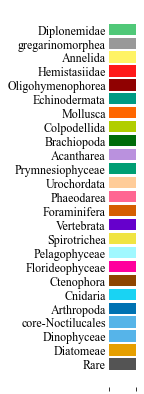

In [26]:
# extract the x labels and y values from the dictionary
x_labels = list(tax_colors.keys())
y_values = list(tax_colors.values())
y_placeholders = [1] * len(y_values)

# create the bar plot
fig, ax = plt.subplots()
ax.barh(x_labels, y_placeholders, color=y_values)

ax.set_xlabel(None)
ax.set_xticklabels([])

# Remove the frame of the chart
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Remove y ticks, not labels
plt.tick_params(axis='y', which='both', length=0)
ax.set_yticklabels(x_labels, fontsize=12, fontname='Times New Roman')

# Adjust the size
plt.gcf().set_size_inches(0.5, 7)

# Save legend as svg
fig.savefig(f"../../figures/taxonomic_analysis/eukprot_legend_{p_id}.svg", format="svg", bbox_inches='tight')

plt.show()